# Testing the GCN implementation on toy KarateClub dataset from PyG

In [66]:
# # Install torch geometric
# ! pip install torch_geometric
# # Optional dependencies:
# ! pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

In [15]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import time
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx

In [16]:
# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

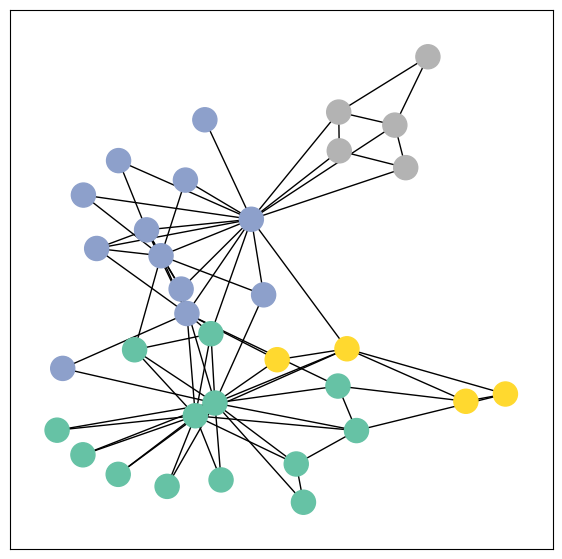

In [17]:
dataset = KarateClub()
data = dataset[0]  # Get the first graph object.

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

### Testing the implemented GCN

In [18]:
from gcn import GCN

Embedding shape: [34, 2]


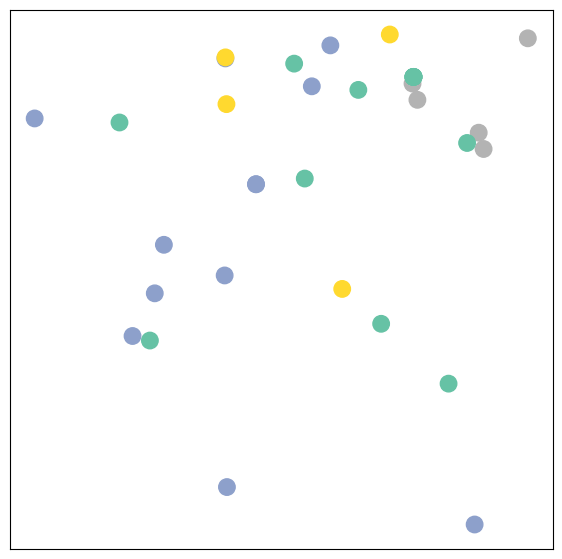

In [19]:
nfeat = dataset.num_features
nhid = 16
nclass = 2
device = torch.device('cpu')

adj_mat = torch.sparse.FloatTensor(
    data.edge_index, 
    torch.ones(data.edge_index.shape[1]), 
    (34, 34)
    )

model = GCN(nfeat=nfeat, nhid=nhid, nclass=nclass, dropout=0.0, device=device)

h = model(data.x.to(device), adj_mat.to(device))

print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

In [64]:
nfeat = dataset.num_features
nhid = 16
nclass = dataset.num_classes
device = torch.device('cpu')
model = GCN(nfeat=nfeat, nhid=nhid, nclass=nclass, dropout=0.5, device=device)

criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    adj_mat = torch.sparse.FloatTensor(
    torch.concat([data.edge_index, torch.range(0, 33, dtype=torch.int64).repeat(2,1)], dim=1), # add self-connections
    torch.ones(data.edge_index.shape[1]+34), 
    (34, 34)
    )

    out = model(data.x, adj_mat)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())
    
    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, accuracy

log = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': []
}
for epoch in range(1000):
    loss, accuracy = train(data)

    log['train_loss'].append(loss.item())
    log['train_acc'].append(accuracy['train'])
    log['val_acc'].append(accuracy['val'])

    # log metrics and losses
    if epoch % 50 == 0:
        print(f"epoch {epoch} | Loss: {loss.item():.4f} | Train Accuracy: {accuracy['train']*100:.2f}% | Validation Accuracy: {accuracy['val']*100:.2f}%")

C:\Users\ebrah\AppData\Local\Temp\ipykernel_39780\4211479127.py:13: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  torch.concat([data.edge_index, torch.range(0, 33, dtype=torch.int64).repeat(2,1)], dim=1), # add self-connections


epoch 0 | Loss: 1.3584 | Train Accuracy: 25.00% | Validation Accuracy: 11.76%
epoch 50 | Loss: 1.2339 | Train Accuracy: 50.00% | Validation Accuracy: 41.18%
epoch 100 | Loss: 0.6971 | Train Accuracy: 75.00% | Validation Accuracy: 73.53%
epoch 150 | Loss: 0.7879 | Train Accuracy: 75.00% | Validation Accuracy: 70.59%
epoch 200 | Loss: 0.7768 | Train Accuracy: 100.00% | Validation Accuracy: 73.53%
epoch 250 | Loss: 0.4905 | Train Accuracy: 100.00% | Validation Accuracy: 73.53%
epoch 300 | Loss: 0.6849 | Train Accuracy: 100.00% | Validation Accuracy: 61.76%
epoch 350 | Loss: 0.4621 | Train Accuracy: 100.00% | Validation Accuracy: 67.65%
epoch 400 | Loss: 0.4153 | Train Accuracy: 100.00% | Validation Accuracy: 73.53%
epoch 450 | Loss: 0.3739 | Train Accuracy: 100.00% | Validation Accuracy: 85.29%
epoch 500 | Loss: 0.3786 | Train Accuracy: 100.00% | Validation Accuracy: 79.41%
epoch 550 | Loss: 0.2319 | Train Accuracy: 100.00% | Validation Accuracy: 76.47%
epoch 600 | Loss: 0.1972 | Train Ac

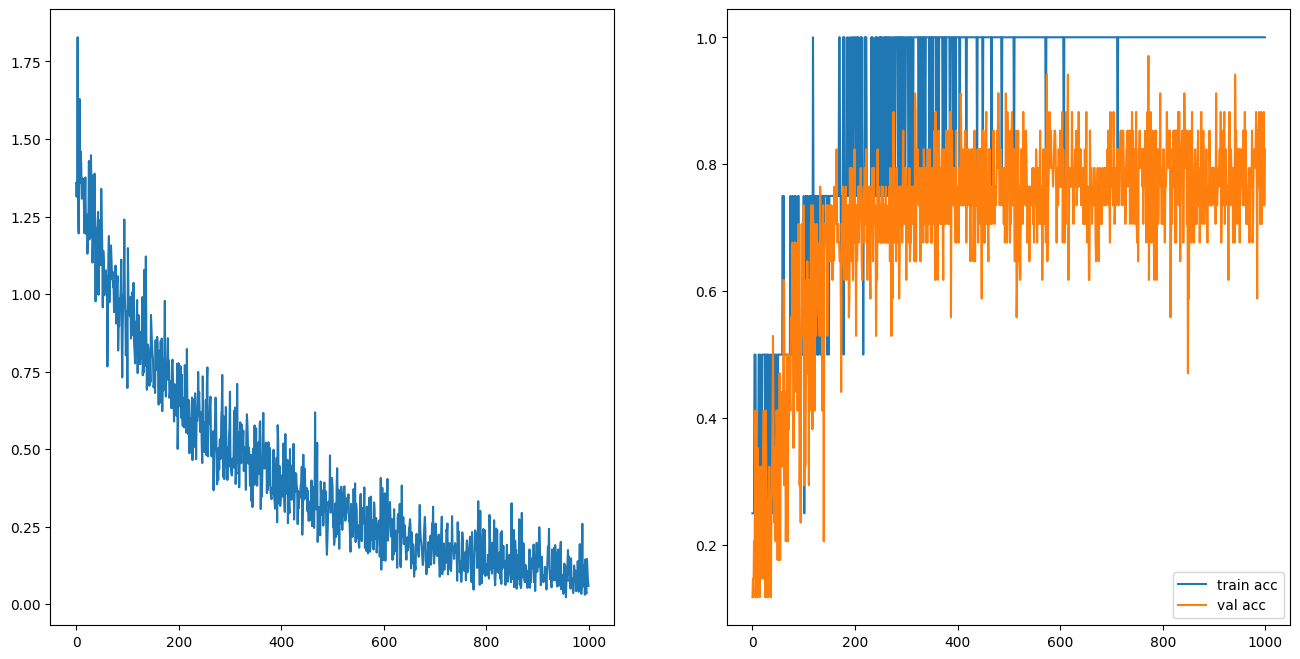

In [65]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(log['train_loss'], label='train loss')

plt.subplot(1, 2, 2)
plt.plot(log['train_acc'], label='train acc')
plt.plot(log['val_acc'], label='val acc')
plt.legend()